# Predicción de sueldos

El objetivo de este notebook es hacer un modelo sencillo que pueda estimar el sueldo de una persona respondiendo una encuesta como la de sysarmy, usando los datos de principios de 2020.

## Baseline

Vamos a tomar un modelo de base para ver cuánto podemos mejorarlo. En análisis previos vimos que las tres características que más definen el sueldo son el género, la ubicación y cuánta gente a cargo tiene la persona. Vamos a hacer un modelo que dada estas tres características memorice el promedio de los valores vistos y estime eso. En caso de ser una combinación no vista puede devolver el promedio general.

In [90]:
import math
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.manifold import TSNE
import xgboost as xgb
%matplotlib inline

In [2]:
df = pd.read_csv('2020.1 - sysarmy - Encuesta de remuneración salarial Argentina - Argentina.csv', skiprows=9)
df.head()

,Me identifico,Tengo,Dónde estás trabajando,Años de experiencia,Años en la empresa actual,Años en el puesto actual,¿Gente a cargo?,Nivel de estudios alcanzado,Estado,Carrera,...,¿Tenés algún tipo de discapacidad?,¿Sentís que esto te dificultó el conseguir trabajo?,¿A qué eventos de tecnología asististe en el último año?,Cantidad de empleados,Actividad principal,¿La recomendás como un buen lugar para trabajar?,¿Cómo calificás las políticas de diversidad e inclusión?,¿A cuántos kilómetros de tu casa queda la oficina?,Beneficios extra,"¿Cuáles considerás que son las mejores empresas de IT para trabajar en este momento, en tu ciudad?"
0,Hombre,40,Catamarca,15.0,0.0,0.0,0,Universitario,Completado,Licenciatura en Sistemas de Información,...,NaN,NaN,NaN,201-500,Otras industrias,6,6,4.0,"Comidas pagas / subvencionadas, Estacionamient...",NaN
1,Mujer,35,Catamarca,15.0,10.0,3.0,5,Posgrado,Completado,Licenciatura en Sistemas de Información,...,NaN,No,NaN,11-50,Servicios / Consultoría de Software / Digital,5,8,2.0,Abono de celular y/o Internet,NaN
2,Hombre,39,Chaco,10.0,5.0,5.0,6,Universitario,Incompleto,Ingeniería en Sistemas de Información,...,NaN,NaN,Ekoparty,11-50,Servicios / Consultoría de Software / Digital,10,10,1.0,"Capacitaciones y/o cursos, Clases de idiomas, ...",NaN
3,Hombre,42,Chaco,18.0,3.0,3.0,0,Universitario,Completado,Licenciatura en Análisis de Sistemas,...,NaN,No,NaN,11-50,Producto basado en Software,5,3,-1.0,"Horarios flexibles, Sueldo dolarizado, WFH (Tr...",NaN
4,Hombre,29,Chaco,4.0,0.0,0.0,1,Universitario,Completado,Ingeniería Electrónica,...,NaN,NaN,"Pynea, Autodefensa digital",201-500,Otras industrias,8,9,5.0,"Abono de celular y/o Internet, Comidas pagas /...",NaN


In [3]:
df.T.index

Index(['Me identifico', 'Tengo', 'Dónde estás trabajando',
       'Años de experiencia', 'Años en la empresa actual',
       'Años en el puesto actual', '¿Gente a cargo?',
       'Nivel de estudios alcanzado', 'Estado', 'Carrera', 'Universidad',
       'Realizaste cursos de especialización',
       '¿Contribuís a proyectos open source?', '¿Programás como hobbie?',
       'Trabajo de', 'Plataformas', 'Lenguajes de programación',
       'Frameworks, herramientas y librerías', 'Bases de datos',
       'QA / Testing', 'IDEs', '¿Qué SO usás en tu laptop/PC para trabajar?',
       '¿Y en tu celular?', '¿Tenés guardias?', 'Cuánto cobrás por guardia',
       '¿Porcentaje, bruto o neto?', 'Tipo de contrato',
       'Salario mensual BRUTO (en tu moneda local)',
       'Salario mensual NETO (en tu moneda local)',
       '¿Qué tan conforme estás con tu sueldo?',
       'Cómo creés que está tu sueldo con respecto al último semestre',
       'Recibís algún tipo de bono', 'A qué está atado el bono',


In [4]:
df[['Me identifico', 'Dónde estás trabajando', '¿Gente a cargo?']]

,Me identifico,Dónde estás trabajando,¿Gente a cargo?
0,Hombre,Catamarca,0
1,Mujer,Catamarca,5
2,Hombre,Chaco,6
3,Hombre,Chaco,0
4,Hombre,Chaco,1
...,...,...,...
5977,Hombre,Tucumán,0
5978,Hombre,Tucumán,1
5979,Hombre,Tucumán,0
5980,Mujer,Tucumán,6


In [5]:
df.groupby('Me identifico').size()

Me identifico
Hombre    5081
Mujer      872
Otros       29
dtype: int64

In [6]:
df.groupby('Dónde estás trabajando').size()

Dónde estás trabajando
Catamarca                             2
Chaco                                33
Chubut                               22
Ciudad Autónoma de Buenos Aires    4105
Corrientes                           16
Córdoba                             316
Entre Ríos                           41
Formosa                               3
GBA                                 432
Jujuy                                15
La Pampa                              2
La Rioja                              8
Mendoza                             112
Misiones                             22
Neuquén                              26
Provincia de Buenos Aires           457
Río Negro                            23
Salta                                10
San Juan                              6
San Luis                              6
Santa Cruz                            2
Santa Fe                            287
Santiago del Estero                   4
Tierra del Fuego                      5
Tucumán          

In [7]:
df.groupby('¿Gente a cargo?').size()

¿Gente a cargo?
0                            4479
1                             278
10                             72
100                             2
105                             1
11                              9
110                             1
12                             21
120                             1
13                              7
130                             1
14                             15
15                             32
150                             1
1555555555555555555555555       1
16                              4
160                             1
17                              2
18                              6
19                              3
2                             274
20                             33
200                             2
21                              1
22                              4
23                              2
230                             1
24                              2
25                              

El género y provincia son variables categóricas, es decir que pueden obtener un conjunto de valores, mientras que gente a cargo es un número. Vemos también que algunas categorías tienen pocos datos, como género no binario o la provincia de Catamarca. En general esto va a ser un problema porque no va a generalizar muy bien ningún modelo con tan poca información.

Veamos si podemos agrupar estos.

In [8]:
df[['Me identifico', 'Salario mensual BRUTO (en tu moneda local)']].groupby('Me identifico').median()

,Salario mensual BRUTO (en tu moneda local)
Me identifico,
Hombre,75000.0
Mujer,60000.0
Otros,55000.0


In [9]:
df_provinces = df[['Dónde estás trabajando', 'Salario mensual BRUTO (en tu moneda local)']].groupby('Dónde estás trabajando').agg(['median', 'count']).sort_values(('Salario mensual BRUTO (en tu moneda local)', 'median'))
df_provinces

Salario mensual BRUTO (en tu moneda local)  \
                                                                    median   
Dónde estás trabajando                                                       
Santiago del Estero                                              41500.000   
Corrientes                                                       42100.000   
La Rioja                                                         43500.000   
Jujuy                                                            45000.000   
Misiones                                                         46000.000   
Catamarca                                                        50500.000   
Mendoza                                                          55000.000   
Santa Cruz                                                       57500.000   
Entre Ríos                                                       59000.000   
Neuquén                                                          62500.000   
Provincia de Buenos Aires                                        65000.000   
Chaco                                                            65784.000   
Tucumán                                                          66000.000   
GBA                                                              66154.500   
Salta                                                            66950.500   
Córdoba                                                          72500.000   
San Juan                                                         72667.375   
Santa Fe                                                         73000.000   
Ciudad Autónoma de Buenos Aires                                  75000.000   
Río Negro                                                        78000.000   
Formosa                                                          80000.000   
Chubut                                                           83000.000   
San Luis                                                         97000.000   
La Pampa                                                        105250.000   
Tierra del Fuego                                                120000.000   

                                       
                                count  
Dónde estás trabajando                 
Santiago del Estero                 4  
Corrientes                         16  
La Rioja                            8  
Jujuy                              15  
Misiones                           22  
Catamarca                           2  
Mendoza                           112  
Santa Cruz                          2  
Entre Ríos                         41  
Neuquén                            26  
Provincia de Buenos Aires         457  
Chaco                              33  
Tucumán                            27  
GBA                               432  
Salta                              10  
Córdoba                           316  
San Juan                            6  
Santa Fe                          287  
Ciudad Autónoma de Buenos Aires  4105  
Río Negro                          23  
Formosa                             3  
Chubut                             22  
San Luis                            6  
La Pampa                            2  
Tierra del Fuego                    5

In [10]:
provinces_geo = gpd.read_file('provincias_argentinas_polygon.geojson')
provinces_geo.head()

,cartodb_id,description,name,provincia,id,codpcia,c_indec,id_dyp,geometry
0,1,,,Ciudad Autónoma de Buenos Aires,1,1,2,1,"MULTIPOLYGON (((-58.39007 -34.66230, -58.39037..."
1,3,,,Catamarca,3,3,10,4,"MULTIPOLYGON (((-66.59111 -26.17318, -66.58961..."
2,4,,,Chaco,4,4,22,6,"MULTIPOLYGON (((-62.34757 -24.11021, -62.34407..."
3,5,,,Chubut,5,5,26,7,"MULTIPOLYGON (((-71.77158 -41.99955, -71.67446..."
4,7,,,Corrientes,7,7,18,5,"MULTIPOLYGON (((-58.89298 -27.99935, -58.89182..."


In [11]:
provinces_geo.provincia

0                Ciudad Autónoma de Buenos Aires
1                                      Catamarca
2                                          Chaco
3                                         Chubut
4                                     Corrientes
5                                     Entre Ríos
6                                        Formosa
7                                          Jujuy
8                                       La Pampa
9                                       La Rioja
10                                       Mendoza
11                                      Misiones
12                                       Neuquén
13                                     Río Negro
14                                         Salta
15                                      San Juan
16                                      San Luis
17                                    Santa Cruz
18                                      Santa Fe
19                           Santiago del Estero
20                  

In [12]:
provinces_geo['provincia'] = provinces_geo['provincia'].apply(lambda x: "Tierra del Fuego" if x == "Tierra del Fuego e Islas del Atlántico Sur" else x)

In [13]:
provinces = provinces_geo.join(df_provinces['Salario mensual BRUTO (en tu moneda local)'], on=['provincia'])
provinces

,cartodb_id,description,name,provincia,id,codpcia,c_indec,id_dyp,geometry,median,count
0,1,,,Ciudad Autónoma de Buenos Aires,1,1,2,1,"MULTIPOLYGON (((-58.39007 -34.66230, -58.39037...",75000.000,4105
1,3,,,Catamarca,3,3,10,4,"MULTIPOLYGON (((-66.59111 -26.17318, -66.58961...",50500.000,2
2,4,,,Chaco,4,4,22,6,"MULTIPOLYGON (((-62.34757 -24.11021, -62.34407...",65784.000,33
3,5,,,Chubut,5,5,26,7,"MULTIPOLYGON (((-71.77158 -41.99955, -71.67446...",83000.000,22
4,7,,,Corrientes,7,7,18,5,"MULTIPOLYGON (((-58.89298 -27.99935, -58.89182...",42100.000,16
5,8,,,Entre Ríos,8,8,30,8,"MULTIPOLYGON (((-59.66084 -30.34857, -59.65614...",59000.000,41
6,9,,,Formosa,9,9,34,9,"MULTIPOLYGON (((-62.34465 -22.45495, -62.33563...",80000.000,3
7,10,,,Jujuy,10,10,38,10,"MULTIPOLYGON (((-64.44379 -23.63491, -64.44048...",45000.000,15
8,11,,,La Pampa,11,11,42,11,"MULTIPOLYGON (((-65.10672 -34.99768, -65.02612...",105250.000,2
9,12,,,La Rioja,12,12,46,12,"MULTIPOLYGON (((-69.09436 -27.77274, -69.01274...",43500.000,8


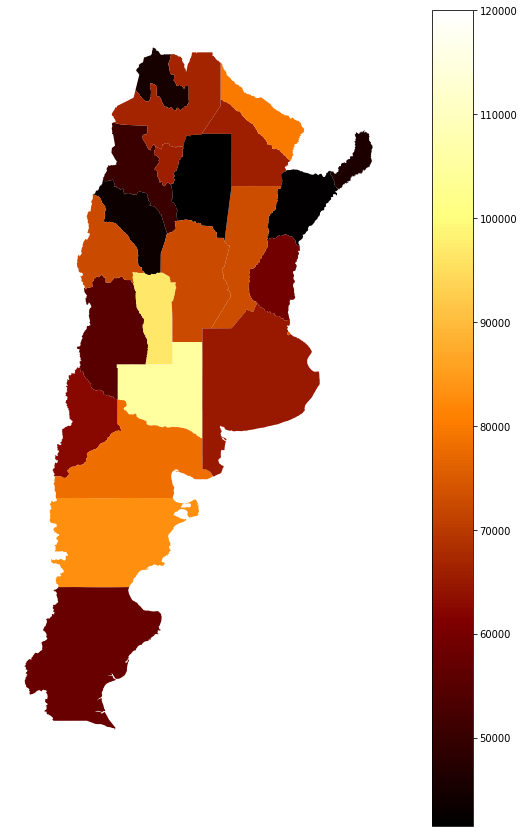

In [14]:
f, ax = plt.subplots(1, figsize=(15, 15))
ax = provinces.plot(column='median', cmap='afmhot', ax=ax, legend=True)
ax.axis('off')
plt.show()

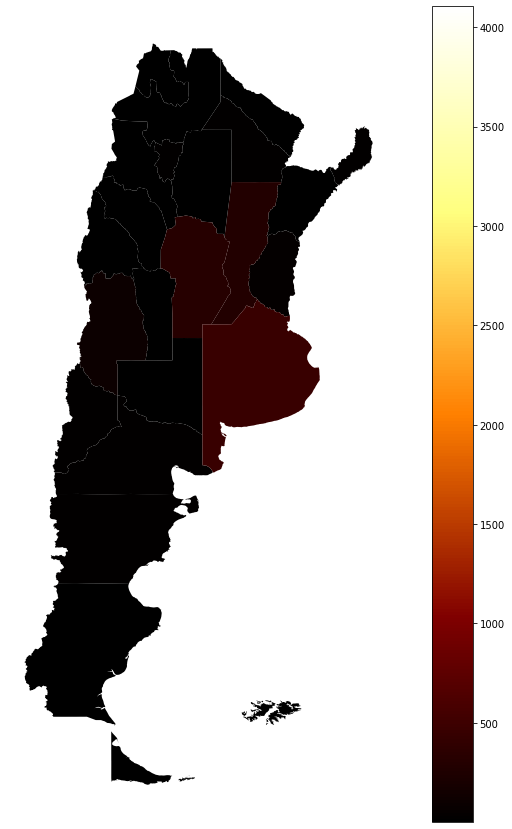

In [15]:
f, ax = plt.subplots(1, figsize=(15, 15))
ax = provinces.plot(column='count', cmap='afmhot', ax=ax, legend=True)
ax.axis('off')
plt.show()

Como la escala está dominada por CABA, apenas podemos ver que PBA, Santa Fe y Córdoba tienen datos y el resto del país casi nada. Usemos logaritmo en base 10 para ver la orden de magnitud de cada provincia.

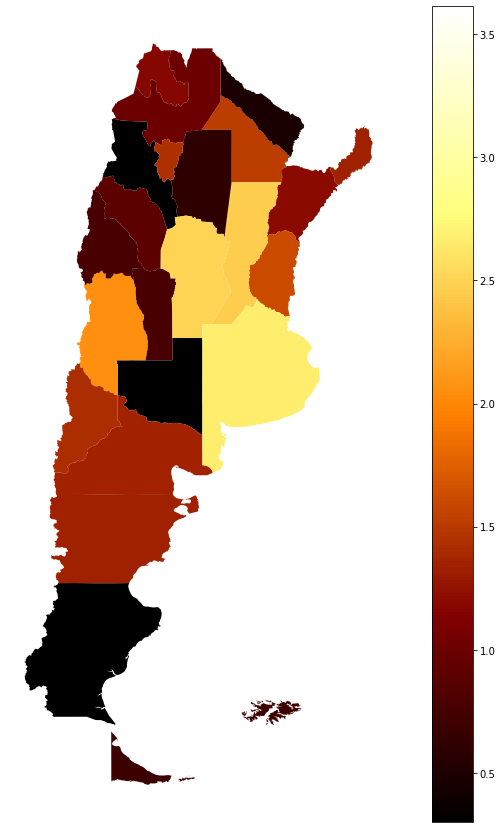

In [16]:
provinces['log(count)'] = provinces['count'].apply(lambda x: math.log10(x))
f, ax = plt.subplots(1, figsize=(15, 15))
ax = provinces.plot(column='log(count)', cmap='afmhot', ax=ax, legend=True)
ax.axis('off')
plt.show()

Vemos algún patrón en estos gráficos. El área de la Pampa Húmeda (Provincia de Buenos Aires, Santa Fe, Córdoba, La Pampa) parece tener más datos, y valores más altos. El Noroeste (Jujuy, Salta, Tucumán, La Rioja, Catamarca) tienen menos observaciones y promedios más bajos. En la Patagonia (Neuquén, Río Negro, Chubut, Santa Cruz) Santa Cruz parece tener un sueldo más bajo que el resto, pero vemos que son pocas observaciones. Pasa lo opuesto en el norte, donde Formosa es más alto pero sólo con 3 personas. Cuyo (Mendoza, San Luis, San Juan) parece ser menos homogéneo, sabiendo que San Luis tiene políticas de incentivo a la actividad económica tiene sentido.

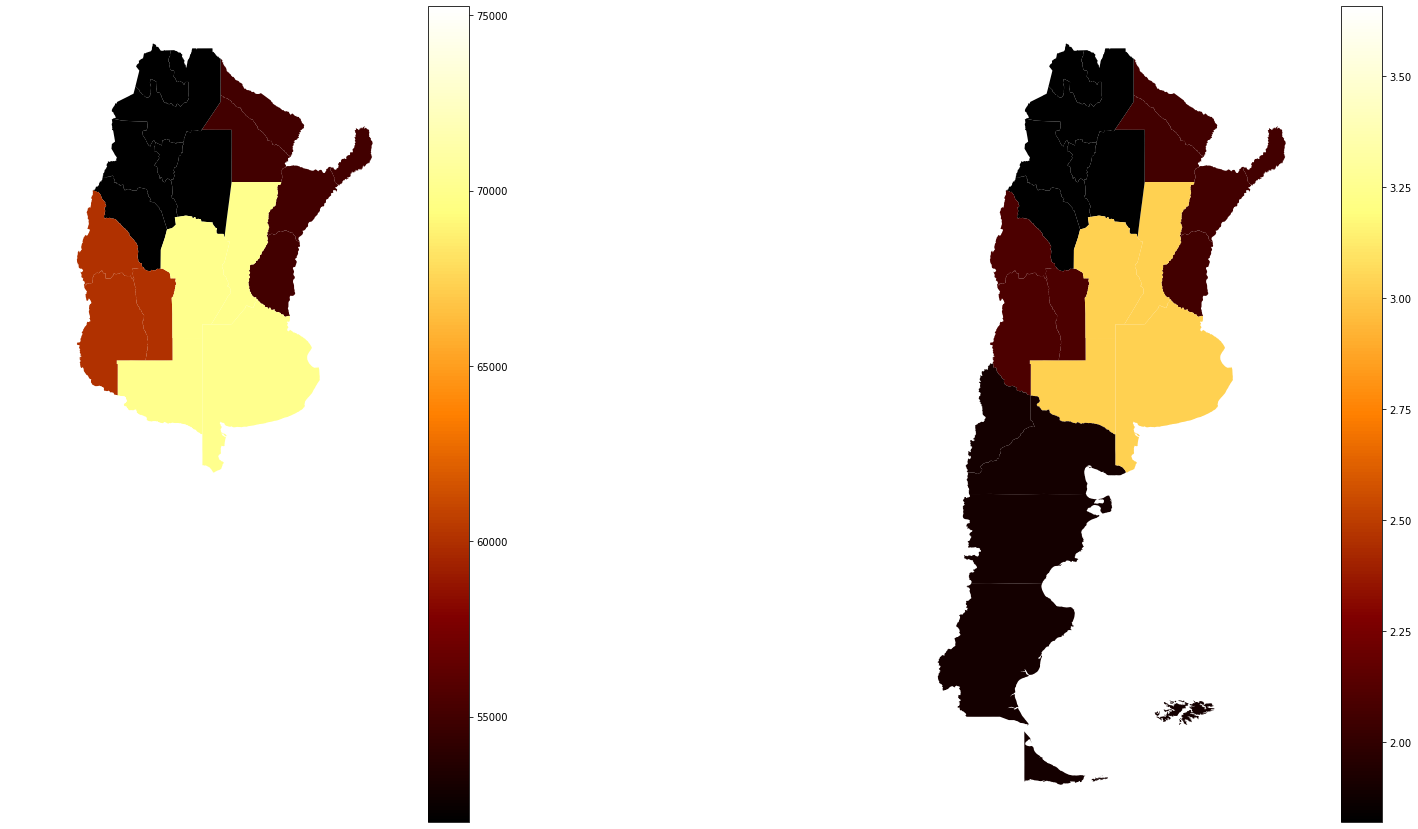

In [17]:
regions_map = {
    'Ciudad Autónoma de Buenos Aires': 'AMBA',
    'GBA': 'AMBA',
    'Catamarca': 'NOA',
    'Chaco': 'NEA',
    'Chubut': 'Patagonia',
    'Corrientes': 'NEA',
    'Entre Ríos': 'NEA',
    'Formosa': 'NEA',
    'Jujuy': 'NOA',
    'La Pampa': 'Pampa',
    'La Rioja': 'NOA',
    'Mendoza': 'Cuyo',
    'Misiones': 'NEA',
    'Neuquén': 'Patagonia',
    'Río Negro': 'Patagonia',
    'Salta': 'NOA',
    'San Juan': 'Cuyo',
    'San Luis': 'Cuyo',
    'Santa Cruz': 'Patagonia',
    'Santa Fe': 'Pampa',
    'Santiago del Estero': 'NOA',
    'Tucumán': 'NOA',
    'Córdoba': 'Pampa',
    'Provincia de Buenos Aires': 'Pampa',
    'Tierra del Fuego': 'Patagonia',
}
provinces_geo['region'] = provinces_geo['provincia'].apply(lambda x: regions_map[x])
df['region'] = df['Dónde estás trabajando'].apply(lambda x: regions_map[x])
df_regions = df[['region', 'Salario mensual BRUTO (en tu moneda local)']].groupby('region').agg(['median', 'count']).sort_values(('Salario mensual BRUTO (en tu moneda local)', 'median'))

regions = provinces_geo.join(df_regions['Salario mensual BRUTO (en tu moneda local)'], on=['region'])
regions['log(count)'] = regions['count'].apply(lambda x: math.log10(x))


f, (ax0, ax1) = plt.subplots(ncols=2, figsize=(30, 15))
ax0 = regions.plot(column='median', cmap='afmhot', ax=ax0, legend=True)
ax0.axis('off')

ax1 = regions.plot(column='log(count)', cmap='afmhot', ax=ax1, legend=True)
ax1.axis('off')

plt.show()

Ahora tenemos una mediana para cada región, y tenemos muestra de dos dígitos o más en cada una.

/home/seppo/.local/share/virtualenvs/sysarmy-sueldos-2020.1-QyVfVxlk/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


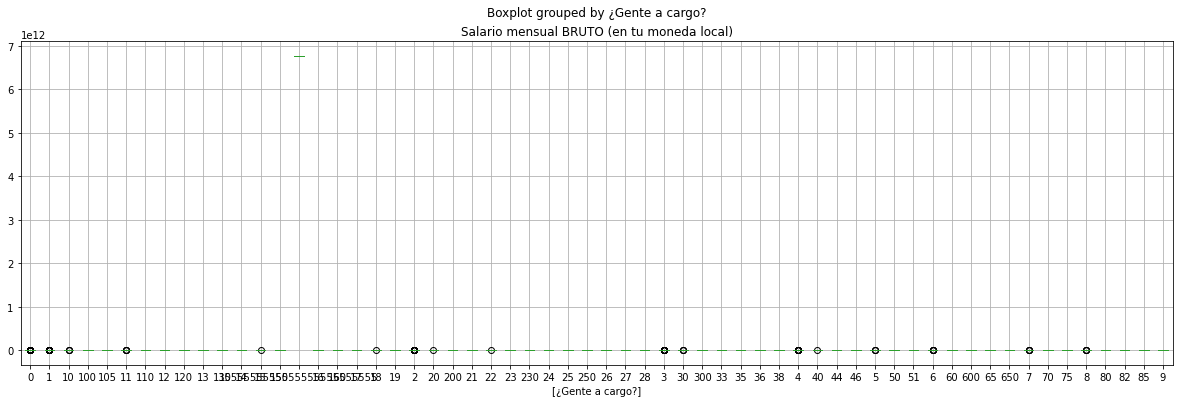

In [18]:
df[['¿Gente a cargo?', 'Salario mensual BRUTO (en tu moneda local)']].boxplot(by='¿Gente a cargo?', figsize=(20, 6));

In [19]:
df['Salario mensual BRUTO (en tu moneda local)'].max()

6777729990111.0

In [20]:
df = df[df['Salario mensual BRUTO (en tu moneda local)'] < 1_000_000]

/home/seppo/.local/share/virtualenvs/sysarmy-sueldos-2020.1-QyVfVxlk/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


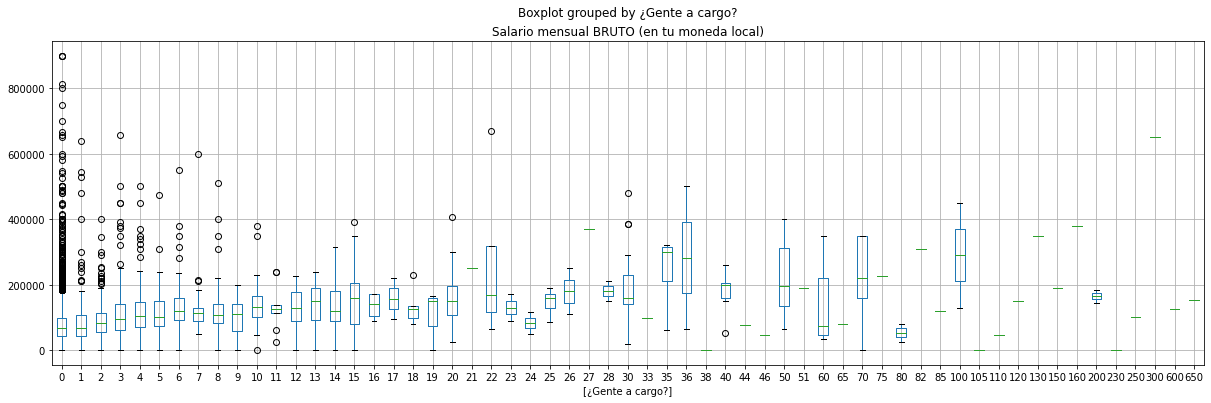

In [21]:
df[['¿Gente a cargo?', 'Salario mensual BRUTO (en tu moneda local)']].astype(int).sort_values(by='¿Gente a cargo?').boxplot(by='¿Gente a cargo?', figsize=(20, 6));

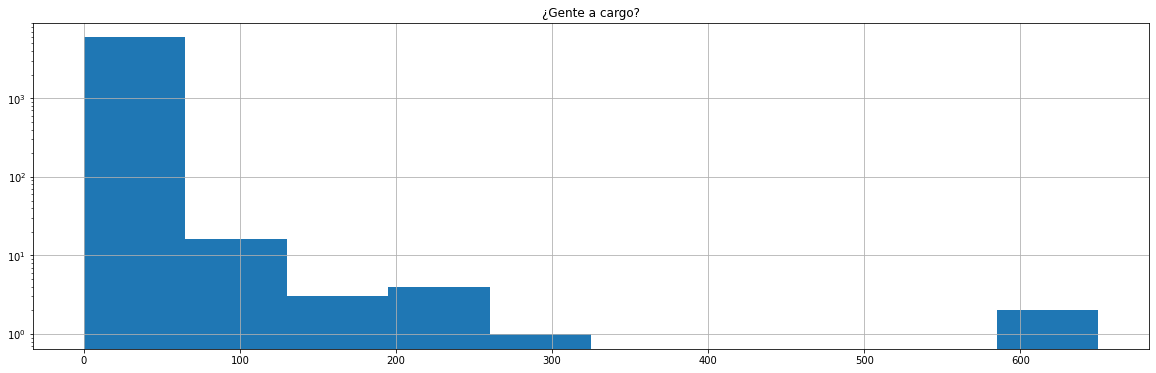

In [22]:
df[['¿Gente a cargo?']].astype(int).sort_values(by='¿Gente a cargo?').hist(figsize=(20, 6), log=True);

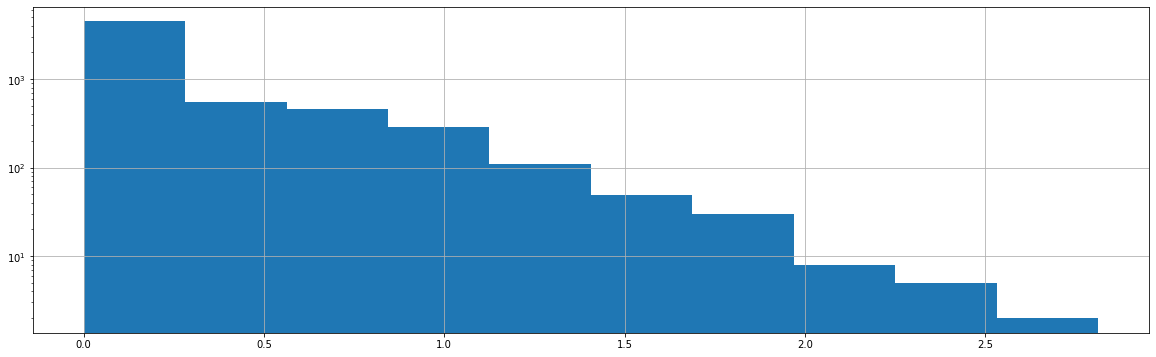

In [23]:
df['¿Gente a cargo?'].astype(int).sort_values().apply(lambda x: math.log10(x+1)).hist(figsize=(20, 6), log=True);

In [24]:
g = df['¿Gente a cargo?'].astype(int)
pd.qcut(g, 10, duplicates='drop', retbins=True)[1]

array([  0.,   2.,   5., 650.])

/home/seppo/.local/share/virtualenvs/sysarmy-sueldos-2020.1-QyVfVxlk/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


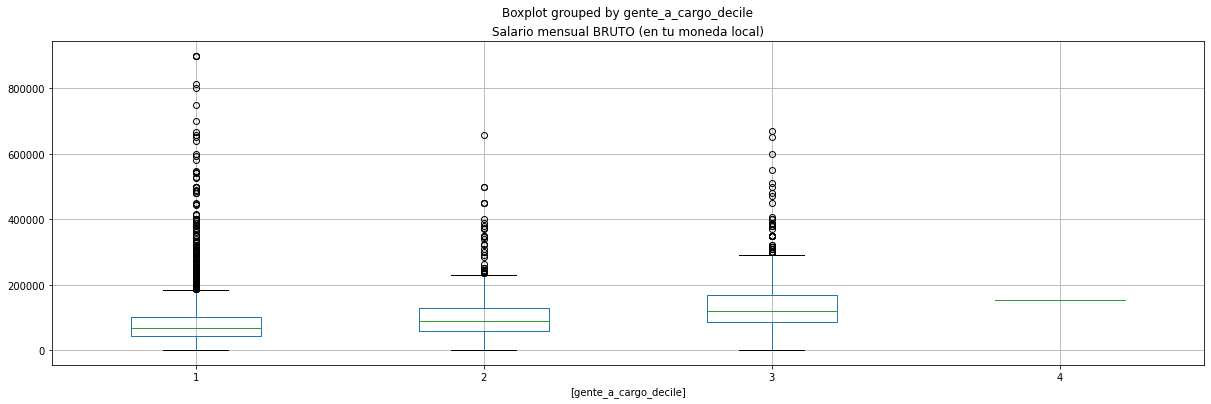

In [25]:
deciles = pd.qcut(g, 10, duplicates='drop', retbins=True)[1]
df['gente_a_cargo_decile'] = df['¿Gente a cargo?'].astype(int).apply(lambda x: (deciles <= x).sum())
df[['gente_a_cargo_decile', 'Salario mensual BRUTO (en tu moneda local)']].astype(int).sort_values(by='gente_a_cargo_decile').boxplot(by='gente_a_cargo_decile', figsize=(20, 6));

Ahora ya estamos listos para armar una predicción básica. Calculamos el promedio para la gente de la misma región geográfica, mismo género (considerando "otro" como "mujer" por ser más parecido su sueldo) y mismo decil con gente a cargo.

In [26]:
gender_map = {
    'Hombre': True,
    'Mujer': False,
    'Otros': False,
}
class BaseModel:
    def __init__(self, num_gente_a_cargo_groups=10):
        self.num_gente_a_cargo_groups = num_gente_a_cargo_groups

    def _get_df(self, X):
        df = pd.DataFrame()
        df['region'] = X['Dónde estás trabajando'].apply(lambda x: regions_map[x])
        df['gender'] = X['Me identifico'].apply(lambda x: gender_map[x])
        df['gente_a_cargo_group'] = X['¿Gente a cargo?'].astype(int).apply(lambda x: (self.groups_ <= x).sum())
        df['key'] = df.apply(lambda row: '{},{},{}'.format(row['region'], row['gender'], row['gente_a_cargo_group']), axis=1)
        return df

    def get_params(self, deep=True):
        return {'num_gente_a_cargo_groups': self.num_gente_a_cargo_groups}

    def set_params(self, **params):
        if 'num_gente_a_cargo_groups' in params:
            self.num_gente_a_cargo_groups = params['num_gente_a_cargo_groups']
    
    def fit(self, X, y):
        self.groups_ = pd.qcut(X['¿Gente a cargo?'].astype(int), self.num_gente_a_cargo_groups, duplicates='drop', retbins=True)[1]
        
        df = self._get_df(X)
        df['value'] = y
        self.mean_ = y.mean()
        self.means_ = df[['key', 'value']].groupby('key').mean().to_dict()['value']
        return self
    
    def predict(self, X):
        df = self._get_df(X)
        return df['key'].apply(lambda key: self.means_.get(key, self.mean_)).rename('y_pred')
    
    def score(self, X, y):
        return r2_score(y, self.predict(X))

X, y = df[['Me identifico', 'Dónde estás trabajando', '¿Gente a cargo?']], df['Salario mensual BRUTO (en tu moneda local)']
m = BaseModel()
m.fit(X, y).score(X, y)

0.0756538701171876

In [27]:
cross_val_score(BaseModel(), X, y)

array([ 0.05912578,  0.06624877,  0.01944449,  0.02328854, -0.01219801])

In [28]:
best_p = 10
best_s = cross_val_score(BaseModel(best_p), X, y).mean()
for i in range(1, 100):
    s = cross_val_score(BaseModel(i), X, y).mean()
    if s > best_s:
        best_s = s
        best_p = i
(best_s, best_p)

(0.04011411251863235, 37)

Este modelo es bastante peor de lo que esperaba. Veamos un modelo de regresión lineal con estos mismos datos.

In [28]:
gender_map = {
    'Hombre': True,
    'Mujer': False,
    'Otros': False,
}
class LinearModel:
    def _get_df(self, X):
        df = pd.DataFrame()
        df['region'] = X['Dónde estás trabajando'].apply(lambda x: self.region_map_.get(regions_map[x], self.mean_))
        df['gender'] = X['Me identifico'].apply(lambda x: self.gender_map_.get(gender_map[x], self.mean_))
        df['log_gente_a_cargo'] = X['¿Gente a cargo?'].astype(int).apply(lambda x: math.log10(x+1))
        return df

    def get_params(self, deep=True):
        return {}

    def set_params(self, **params):
        return
    
    def fit(self, X, y):
        self.mean_ = y.mean()
        self.region_map_ = pd.concat((X['Dónde estás trabajando'].apply(lambda x: regions_map[x]).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.gender_map_ = pd.concat((X['Me identifico'].apply(lambda x: gender_map[x]).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
                                     
        df = self._get_df(X)
        self.model_ = LinearRegression()
        self.model_.fit(df, y)
        return self
    
    def predict(self, X):
        return self.model_.predict(self._get_df(X))
    
    def score(self, X, y):
        return r2_score(y, self.predict(X))

X, y = df[['Me identifico', 'Dónde estás trabajando', '¿Gente a cargo?']], df['Salario mensual BRUTO (en tu moneda local)']
cross_val_score(LinearModel(), X, y).mean()

0.045472258331214224

In [29]:
gender_map = {
    'Hombre': True,
    'Mujer': False,
    'Otros': False,
}
class LinearModel:
    def _get_df(self, X):
        df = pd.DataFrame()
        df['region'] = X['Dónde estás trabajando'].apply(lambda x: self.region_map_.get(x, self.mean_))
        df['gender'] = X['Me identifico'].apply(lambda x: self.gender_map_.get(gender_map[x], self.mean_))
        df['log_gente_a_cargo'] = X['¿Gente a cargo?'].astype(int).apply(lambda x: math.log10(x+1))
        return df

    def get_params(self, deep=True):
        return {}

    def set_params(self, **params):
        return
    
    def fit(self, X, y):
        self.mean_ = y.mean()
        self.region_map_ = pd.concat((X['Dónde estás trabajando'].rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.gender_map_ = pd.concat((X['Me identifico'].apply(lambda x: gender_map[x]).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
                                     
        df = self._get_df(X)
        self.model_ = LinearRegression()
        self.model_.fit(df, y)
        return self
    
    def predict(self, X):
        return self.model_.predict(self._get_df(X))
    
    def score(self, X, y):
        return r2_score(y, self.predict(X))

X, y = df[['Me identifico', 'Dónde estás trabajando', '¿Gente a cargo?']], df['Salario mensual BRUTO (en tu moneda local)']
cross_val_score(LinearModel(), X, y).mean()

0.04569610636696928

In [30]:
gender_map = {
    'Hombre': 2,
    'Mujer': 1,
    'Otros': 0,
}
class LinearModel:
    def _get_df(self, X):
        df = pd.DataFrame()
        df['region'] = X['Dónde estás trabajando'].apply(lambda x: self.region_map_.get(x, self.mean_))
        df['gender'] = X['Me identifico'].apply(lambda x: self.gender_map_.get(gender_map[x], self.mean_))
        df['log_gente_a_cargo'] = X['¿Gente a cargo?'].astype(int).apply(lambda x: math.log10(x+1))
        return df

    def get_params(self, deep=True):
        return {}

    def set_params(self, **params):
        return
    
    def fit(self, X, y):
        self.mean_ = y.mean()
        self.region_map_ = pd.concat((X['Dónde estás trabajando'].rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.gender_map_ = pd.concat((X['Me identifico'].apply(lambda x: gender_map[x]).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
                                     
        df = self._get_df(X)
        self.model_ = LinearRegression()
        self.model_.fit(df, y)
        return self
    
    def predict(self, X):
        return self.model_.predict(self._get_df(X))
    
    def score(self, X, y):
        return r2_score(y, self.predict(X))

X, y = df[['Me identifico', 'Dónde estás trabajando', '¿Gente a cargo?']], df['Salario mensual BRUTO (en tu moneda local)']
cross_val_score(LinearModel(), X, y).mean()

0.045596020642121184

Probando no agrupar otros con mujeres el modelo empeora, dejando las provincias sin agrupar el modelo mejora. Usar logaritmo en vez de deciles para gente a cargo mejora (¡y es más sencillo de implementar!). Quedemosnos el mejor modelo que tenemos hasta ahora y agreguemos experiencia y nivel de estudio.

In [31]:
gender_map = {
    'Hombre': True,
    'Mujer': False,
    'Otros': False,
}
class LinearModel:
    def _get_df(self, X):
        df = pd.DataFrame()
        df['region'] = X['Dónde estás trabajando'].apply(lambda x: self.region_map_.get(x, self.mean_))
        df['gender'] = X['Me identifico'].apply(lambda x: self.gender_map_.get(gender_map[x], self.mean_))
        df['log_gente_a_cargo'] = X['¿Gente a cargo?'].astype(int).apply(lambda x: math.log10(x+1))
        df['exp'] = X['Años de experiencia'].apply(lambda x: math.log10(x+1))
        return df

    def get_params(self, deep=True):
        return {}

    def set_params(self, **params):
        return
    
    def fit(self, X, y):
        self.mean_ = y.mean()
        self.region_map_ = pd.concat((X['Dónde estás trabajando'].rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.gender_map_ = pd.concat((X['Me identifico'].apply(lambda x: gender_map[x]).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
                                     
        df = self._get_df(X)
        self.model_ = LinearRegression()
        self.model_.fit(df, y)
        return self
    
    def predict(self, X):
        return self.model_.predict(self._get_df(X))
    
    def score(self, X, y):
        return r2_score(y, self.predict(X))

X, y = df[['Me identifico', 'Dónde estás trabajando', '¿Gente a cargo?', 'Años de experiencia', 'Nivel de estudios alcanzado', 'Estado']], df['Salario mensual BRUTO (en tu moneda local)']
m = LinearModel()
cross_val_score(LinearModel(), X, y).mean()

0.14055117647443893

In [32]:
df['Estado'].value_counts()

Completado    2932
En curso      1748
Incompleto    1292
Name: Estado, dtype: int64

In [33]:
df['Nivel de estudios alcanzado'].value_counts()

Universitario    3935
Terciario        1132
Secundario        553
Posgrado          321
Doctorado          21
Posdoctorado        8
Primario            2
Name: Nivel de estudios alcanzado, dtype: int64

In [34]:
class LinearModel:
    def _get_df(self, X):
        df = pd.DataFrame()
        df['region'] = X['Dónde estás trabajando'].apply(lambda x: self.region_map_.get(x, self.mean_))
        df['gender'] = X['Me identifico'].apply(lambda x: self.gender_map_.get(gender_map[x], self.mean_))
        df['log_gente_a_cargo'] = X['¿Gente a cargo?'].astype(int).apply(lambda x: math.log10(x+1))
        df['exp'] = X['Años de experiencia'].apply(lambda x: math.log10(x+1))
        df['study'] = X[['Nivel de estudios alcanzado', 'Estado']].apply(lambda x: self.study_.get(' '.join(x), self.mean_), axis=1)
        return df

    def get_params(self, deep=True):
        return {}

    def set_params(self, **params):
        return
    
    def fit(self, X, y):
        self.mean_ = y.mean()
        self.region_map_ = pd.concat((X['Dónde estás trabajando'].rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.gender_map_ = pd.concat((X['Me identifico'].apply(lambda x: gender_map[x]).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.study_ = pd.concat((X[['Nivel de estudios alcanzado', 'Estado']].apply(lambda x: ' '.join(x), axis=1).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']

        df = self._get_df(X)
        self.model_ = LinearRegression()
        self.model_.fit(df, y)
        return self
    
    def predict(self, X):
        return self.model_.predict(self._get_df(X))
    
    def score(self, X, y):
        return r2_score(y, self.predict(X))

X, y = df[['Me identifico', 'Dónde estás trabajando', '¿Gente a cargo?', 'Años de experiencia', 'Nivel de estudios alcanzado', 'Estado']], df['Salario mensual BRUTO (en tu moneda local)']
m = LinearModel()
cross_val_score(LinearModel(), X, y).mean()

0.15781202277215325

In [35]:
df['Carrera'].value_counts()

Ingeniería en Sistemas de Información                     1078
Ingeniería en Informática                                  741
Analista de Sistemas                                       563
Licenciatura en Sistemas de Información                    320
Licenciatura en Ciencias dela Computación                  271
                                                          ... 
PERIODISMO                                                   1
Traductorado Cientifico Literario                            1
Tecnicatura Universitaria en Automatización Industrial       1
Licenciatura en ciencias nauticas                            1
Lic en fisica                                                1
Name: Carrera, Length: 572, dtype: int64

In [36]:
df['Universidad'].value_counts()

UTN - Universidad Tecnológica Nacional        1271
UBA - Universidad de Buenos Aires              830
UADE - Universidad Argentina De la Empresa     228
UNLaM - Universidad Nacional de La Matanza     196
UAI - Universidad Abierta Interamericana       162
                                              ... 
Washington and Lee University                    1
ean                                              1
UNC - Manuel Belgrano                            1
Instituto sup. del Milagro                       1
Universidad Nacional de San Juan                 1
Name: Universidad, Length: 848, dtype: int64

In [37]:
class LinearModel:
    def _get_df(self, X):
        df = pd.DataFrame()
        df['region'] = X['Dónde estás trabajando'].apply(lambda x: self.region_map_.get(x, self.mean_))
        df['gender'] = X['Me identifico'].apply(lambda x: self.gender_map_.get(gender_map[x], self.mean_))
        df['log_gente_a_cargo'] = X['¿Gente a cargo?'].astype(int).apply(lambda x: math.log10(x+1))
        df['exp'] = X['Años de experiencia'].apply(lambda x: math.log10(x+1))
        df['study'] = pd.concat((
            X['Nivel de estudios alcanzado'],
            X['Estado'],
            X['Carrera'].apply(lambda x: x if x in self.degrees_ else ''),
            X['Universidad'].apply(lambda x: x if x in self.universities_ else ''),
        ), axis=1).fillna('').apply(lambda x: self.study_.get(' '.join(x), self.mean_), axis=1)
        return df

    def get_params(self, deep=True):
        return {}

    def set_params(self, **params):
        return
    
    def fit(self, X, y):
        self.mean_ = y.mean()
        self.region_map_ = pd.concat((X['Dónde estás trabajando'].rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.gender_map_ = pd.concat((X['Me identifico'].apply(lambda x: gender_map[x]).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.degrees_ = X['Carrera'].value_counts()[X['Carrera'].value_counts() > X.shape[0] / 100].to_dict().keys()
        self.universities_ = X['Universidad'].value_counts()[X['Universidad'].value_counts() > X.shape[0] / 100].to_dict().keys()
        self.study_ = pd.concat((
            pd.concat((
                X['Nivel de estudios alcanzado'],
                X['Estado'],
                X['Carrera'].apply(lambda x: x if x in self.degrees_ else ''),
                X['Universidad'].apply(lambda x: x if x in self.universities_ else ''),
            ), axis=1)
        .apply(lambda x: ' '.join(x), axis=1).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        
        df = self._get_df(X)
        self.model_ = LinearRegression()
        self.model_.fit(df, y)
        return self
    
    def predict(self, X):
        return self.model_.predict(self._get_df(X))
    
    def score(self, X, y):
        return r2_score(y, self.predict(X))

X, y = df[['Me identifico', 'Dónde estás trabajando', '¿Gente a cargo?', 'Años de experiencia', 'Nivel de estudios alcanzado', 'Estado', 'Carrera', 'Universidad']], df['Salario mensual BRUTO (en tu moneda local)']
m = LinearModel()
cross_val_score(LinearModel(), X, y).mean()

0.09204226421744824

In [38]:
class LinearModel:
    def _get_df(self, X):
        df = pd.DataFrame()
        df['region'] = X['Dónde estás trabajando'].apply(lambda x: self.region_map_.get(x, self.mean_))
        df['gender'] = X['Me identifico'].apply(lambda x: self.gender_map_.get(gender_map[x], self.mean_))
        df['log_gente_a_cargo'] = X['¿Gente a cargo?'].astype(int).apply(lambda x: math.log10(x+1))
        df['exp'] = X['Años de experiencia'].apply(lambda x: math.log10(x+1))
        df['study'] = pd.concat((
            X['Nivel de estudios alcanzado'],
            X['Estado'],
            X['Carrera'].apply(lambda x: x if x in self.degrees_ else ''),
        ), axis=1).fillna('').apply(lambda x: self.study_.get(' '.join(x), self.mean_), axis=1)
        return df

    def get_params(self, deep=True):
        return {}

    def set_params(self, **params):
        return
    
    def fit(self, X, y):
        self.mean_ = y.mean()
        self.region_map_ = pd.concat((X['Dónde estás trabajando'].rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.gender_map_ = pd.concat((X['Me identifico'].apply(lambda x: gender_map[x]).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.degrees_ = X['Carrera'].value_counts()[X['Carrera'].value_counts() > X.shape[0] / 100].to_dict().keys()
        self.universities_ = X['Universidad'].value_counts()[X['Universidad'].value_counts() > X.shape[0] / 100].to_dict().keys()
        self.study_ = pd.concat((
            pd.concat((
                X['Nivel de estudios alcanzado'],
                X['Estado'],
                X['Carrera'].apply(lambda x: x if x in self.degrees_ else ''),
            ), axis=1)
        .apply(lambda x: ' '.join(x), axis=1).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        
        df = self._get_df(X)
        self.model_ = LinearRegression()
        self.model_.fit(df, y)
        return self
    
    def predict(self, X):
        return self.model_.predict(self._get_df(X))
    
    def score(self, X, y):
        return r2_score(y, self.predict(X))

X, y = df[['Me identifico', 'Dónde estás trabajando', '¿Gente a cargo?', 'Años de experiencia', 'Nivel de estudios alcanzado', 'Estado', 'Carrera', 'Universidad']], df['Salario mensual BRUTO (en tu moneda local)']
m = LinearModel()
cross_val_score(LinearModel(), X, y).mean()

0.15638080087703565

In [39]:
class LinearModel:
    def _get_df(self, X):
        df = pd.DataFrame()
        df['region'] = X['Dónde estás trabajando'].apply(lambda x: self.region_map_.get(x, self.mean_))
        df['gender'] = X['Me identifico'].apply(lambda x: self.gender_map_.get(gender_map[x], self.mean_))
        df['log_gente_a_cargo'] = X['¿Gente a cargo?'].astype(int).apply(lambda x: math.log10(x+1))
        df['exp'] = X['Años de experiencia'].apply(lambda x: math.log10(x+1))
        df['study'] = pd.concat((
            X['Nivel de estudios alcanzado'],
            X['Estado'],
            X['Carrera'].apply(lambda x: x if x in self.degrees_ else ''),
        ), axis=1).fillna('').apply(lambda x: self.study_.get(' '.join(x), self.mean_), axis=1)
        return df

    def get_params(self, deep=True):
        return {}

    def set_params(self, **params):
        return
    
    def fit(self, X, y):
        self.mean_ = y.mean()
        self.region_map_ = pd.concat((X['Dónde estás trabajando'].rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.gender_map_ = pd.concat((X['Me identifico'].apply(lambda x: gender_map[x]).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.degrees_ = X['Carrera'].value_counts()[X['Carrera'].value_counts() > X.shape[0] * 3 / 100].to_dict().keys()
        self.study_ = pd.concat((
            pd.concat((
                X['Nivel de estudios alcanzado'],
                X['Estado'],
                X['Carrera'].apply(lambda x: x if x in self.degrees_ else ''),
            ), axis=1)
        .apply(lambda x: ' '.join(x), axis=1).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        
        df = self._get_df(X)
        self.model_ = LinearRegression()
        self.model_.fit(df, y)
        return self
    
    def predict(self, X):
        return self.model_.predict(self._get_df(X))
    
    def score(self, X, y):
        return r2_score(y, self.predict(X))

X, y = df[['Me identifico', 'Dónde estás trabajando', '¿Gente a cargo?', 'Años de experiencia', 'Nivel de estudios alcanzado', 'Estado', 'Carrera', 'Universidad']], df['Salario mensual BRUTO (en tu moneda local)']
m = LinearModel()
cross_val_score(LinearModel(), X, y).mean()

0.15988516023297533

In [40]:
class LinearModel:
    def _get_df(self, X):
        df = pd.DataFrame()
        df['region'] = X['Dónde estás trabajando'].apply(lambda x: self.region_map_.get(x, self.mean_))
        df['gender'] = X['Me identifico'].apply(lambda x: self.gender_map_.get(gender_map[x], self.mean_))
        df['log_gente_a_cargo'] = X['¿Gente a cargo?'].astype(int).apply(lambda x: math.log10(x+1))
        df['exp'] = X['Años de experiencia'].apply(lambda x: math.log10(x+1))
        df['study'] = pd.concat((
            X['Nivel de estudios alcanzado'],
            X['Estado'],
            X['Carrera'].apply(lambda x: x if x in self.degrees_ else ''),
            X['Universidad'].apply(lambda x: x if x in self.universities_ else ''),
        ), axis=1).fillna('').apply(lambda x: self.study_.get(' '.join(x), self.mean_), axis=1)
        return df

    def get_params(self, deep=True):
        return {}

    def set_params(self, **params):
        return
    
    def fit(self, X, y):
        self.mean_ = y.mean()
        self.region_map_ = pd.concat((X['Dónde estás trabajando'].rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.gender_map_ = pd.concat((X['Me identifico'].apply(lambda x: gender_map[x]).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.degrees_ = X['Carrera'].value_counts()[X['Carrera'].value_counts() > X.shape[0] * 3 / 100].to_dict().keys()
        self.universities_ = X['Universidad'].value_counts()[X['Universidad'].value_counts() > X.shape[0] * 5 / 100].to_dict().keys()
        self.study_ = pd.concat((
            pd.concat((
                X['Nivel de estudios alcanzado'],
                X['Estado'],
                X['Carrera'].apply(lambda x: x if x in self.degrees_ else ''),
                X['Universidad'].apply(lambda x: x if x in self.universities_ else ''),
            ), axis=1)
        .apply(lambda x: ' '.join(x), axis=1).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        
        df = self._get_df(X)
        self.model_ = LinearRegression()
        self.model_.fit(df, y)
        return self
    
    def predict(self, X):
        return self.model_.predict(self._get_df(X))
    
    def score(self, X, y):
        return r2_score(y, self.predict(X))

X, y = df[['Me identifico', 'Dónde estás trabajando', '¿Gente a cargo?', 'Años de experiencia', 'Nivel de estudios alcanzado', 'Estado', 'Carrera', 'Universidad']], df['Salario mensual BRUTO (en tu moneda local)']
m = LinearModel()
cross_val_score(LinearModel(), X, y).mean()

0.1526299924940517

In [41]:
class LinearModel:
    def _get_df(self, X):
        df = pd.DataFrame()
        df['region'] = X['Dónde estás trabajando'].apply(lambda x: self.region_map_.get(x, self.mean_))
        df['gender'] = X['Me identifico'].apply(lambda x: self.gender_map_.get(gender_map[x], self.mean_))
        df['log_gente_a_cargo'] = X['¿Gente a cargo?'].astype(int).apply(lambda x: math.log10(x+1))
        df['exp'] = X['Años de experiencia'].apply(lambda x: math.log10(x+1))
        df['study'] = pd.concat((
            X['Nivel de estudios alcanzado'],
            X['Estado'],
            X['Carrera'].apply(lambda x: x if x in self.degrees_ else ''),
        ), axis=1).fillna('').apply(lambda x: self.study_.get(' '.join(x), self.mean_), axis=1)
        return df

    def get_params(self, deep=True):
        return {}

    def set_params(self, **params):
        return
    
    def fit(self, X, y):
        self.mean_ = y.mean()
        self.region_map_ = pd.concat((X['Dónde estás trabajando'].rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.gender_map_ = pd.concat((X['Me identifico'].apply(lambda x: gender_map[x]).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.degrees_ = X['Carrera'].value_counts()[X['Carrera'].value_counts() > X.shape[0] * 3 / 100].to_dict().keys()
        self.study_ = pd.concat((
            pd.concat((
                X['Nivel de estudios alcanzado'],
                X['Estado'],
                X['Carrera'].apply(lambda x: x if x in self.degrees_ else ''),
            ), axis=1)
        .apply(lambda x: ' '.join(x), axis=1).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        
        df = self._get_df(X)
        self.model_ = LinearRegression()
        self.model_.fit(df, y)
        return self
    
    def predict(self, X):
        return self.model_.predict(self._get_df(X))
    
    def score(self, X, y):
        return r2_score(y, self.predict(X))

X, y = df[['Me identifico', 'Dónde estás trabajando', '¿Gente a cargo?', 'Años de experiencia', 'Nivel de estudios alcanzado', 'Estado', 'Carrera', 'Universidad']], df['Salario mensual BRUTO (en tu moneda local)']
m = LinearModel()
cross_val_score(LinearModel(), X, y).mean()

0.15988516023297533

## doc2vec

Ya tenemos un modelo base que explica un 16% del sueldo. No es un gran número pero es una base sobre la que trabajar. Muchas de las variables que tenemos son categóricas así que probemos hacer un documento con cada registro y aplicar doc2vec para generar embeddings.
Empecemos sólo con los lenguajes de programación para ver cómo funciona.

In [42]:
documents = [TaggedDocument([x for x in df.iloc[i].fillna('')['Lenguajes de programación'].split(', ') if x], [i]) for i in range(df.shape[0])]
model = Doc2Vec(documents, vector_size=2, epochs=30)

In [43]:
embeddings = [model.docvecs[i] for i in range(len(model.docvecs))]

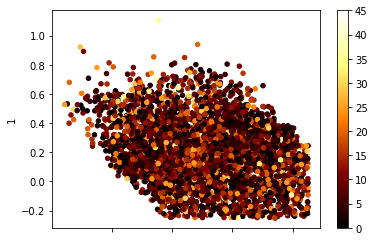

In [44]:
pd.DataFrame(embeddings).plot.scatter(0, 1, c=df['Años de experiencia'], cmap='afmhot');

In [45]:
class EmbeddingModel:
    def get_params(self, deep=True):
        return {}

    def set_params(self, **params):
        return
    
    def fit(self, X, y):
        documents = [TaggedDocument([x for x in X.iloc[i].fillna('')['Lenguajes de programación'].split(', ') if x], [i]) for i in range(X.shape[0])]
        self.doc2vec_ = Doc2Vec(documents, vector_size=4, alpha=0.025, min_count=2, epochs=300)
        self.model_ = LinearRegression()
        self.model_.fit(pd.DataFrame([self.doc2vec_.docvecs[i] for i in range(len(self.doc2vec_.docvecs))]), y)
        return self
    
    def predict(self, X):
        return self.model_.predict([self.doc2vec_.infer_vector([x for x in X.iloc[i].fillna('')['Lenguajes de programación'].split(', ') if x]) for i in range(X.shape[0])])
    
    def score(self, X, y):
        return r2_score(y, self.predict(X))

X, y = df[['Lenguajes de programación']], df['Salario mensual BRUTO (en tu moneda local)']
cross_val_score(EmbeddingModel(), X, y).mean()

0.008280584439386507

In [83]:
class LinearEmbeddingModel:
    def __init__(self, vector_size=1, epochs=1):
        self.vector_size = vector_size
        self.epochs = epochs

    def _row_to_words(self, row):
        return [
            f'{key}={row[key]}'
            for key
            in (
                'Tengo',
                'Realizaste cursos de especialización',
                '¿Contribuís a proyectos open source?',
                '¿Programás como hobbie?',
                'Trabajo de',
                '¿Qué SO usás en tu laptop/PC para trabajar?',
                '¿Y en tu celular?',
                '¿Tenés guardias?',
                'Tipo de contrato',
                'Orientación sexual',
                'Cantidad de empleados',
                'Actividad principal',
            )
        ] + [
            f'{k}={v}' for k in (
                '¿A qué eventos de tecnología asististe en el último año?',
                'Beneficios extra',
                'Plataformas',
                'Lenguajes de programación',
                'Frameworks, herramientas y librerías',
                'Bases de datos',
                'QA / Testing',
                'IDEs',
                'Lenguajes de programación'
            ) for v in row.fillna('')[k].split(', ')
        ]

    def _row_to_embeddings(self, row):
        return pd.Series(self.doc2vec_.infer_vector(self._row_to_words(row)))

    def _get_df(self, X):
        df = pd.DataFrame()
        df['region'] = X['Dónde estás trabajando'].apply(lambda x: self.region_map_.get(x, self.mean_))
        df['gender'] = X['Me identifico'].apply(lambda x: self.gender_map_.get(gender_map[x], self.mean_))
        df['log_gente_a_cargo'] = X['¿Gente a cargo?'].astype(int).apply(lambda x: math.log10(x+1))
        df['exp'] = X['Años de experiencia'].apply(lambda x: math.log10(x+1))
        df['study'] = pd.concat((
            X['Nivel de estudios alcanzado'],
            X['Estado'],
            X['Carrera'].apply(lambda x: x if x in self.degrees_ else ''),
        ), axis=1).fillna('').apply(lambda x: self.study_.get(' '.join(x), self.mean_), axis=1)
        return pd.concat((df, X.apply(lambda row: self._row_to_embeddings(row), axis=1)), axis=1)

    def get_params(self, deep=True):
        return {}

    def set_params(self, **params):
        return
    
    def fit(self, X, y):
        documents = [TaggedDocument(self._row_to_words(X.iloc[i]), [i]) for i in range(X.shape[0])]
        self.doc2vec_ = Doc2Vec(documents, vector_size=self.vector_size, alpha=0.025, min_count=2, epochs=self.epochs)
        self.mean_ = y.mean()
        self.region_map_ = pd.concat((X['Dónde estás trabajando'].rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.gender_map_ = pd.concat((X['Me identifico'].apply(lambda x: gender_map[x]).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.degrees_ = X['Carrera'].value_counts()[X['Carrera'].value_counts() > X.shape[0] * 3 / 100].to_dict().keys()
        self.study_ = pd.concat((
            pd.concat((
                X['Nivel de estudios alcanzado'],
                X['Estado'],
                X['Carrera'].apply(lambda x: x if x in self.degrees_ else ''),
            ), axis=1)
        .apply(lambda x: ' '.join(x), axis=1).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        
        df = self._get_df(X)
        self.model_ = LinearRegression()
        self.model_.fit(df, y)
        return self
    
    def predict(self, X):
        return self.model_.predict(self._get_df(X))
    
    def score(self, X, y):
        return r2_score(y, self.predict(X))

X, y = df, df['Salario mensual BRUTO (en tu moneda local)']
cross_val_score(LinearEmbeddingModel(), X, y).mean()

0.16000891499736603

In [84]:
cross_val_score(LinearEmbeddingModel(vector_size=10, epochs=10), X, y).mean()

0.15981906013320776

In [85]:
cross_val_score(LinearEmbeddingModel(vector_size=10, epochs=100), X, y).mean()

0.16008415113073585

In [86]:
cross_val_score(LinearEmbeddingModel(vector_size=100, epochs=10), X, y).mean()

0.15986304581172256

In [87]:
cross_val_score(LinearEmbeddingModel(vector_size=20, epochs=20), X, y).mean()

0.1598453943802156

In [88]:
cross_val_score(LinearEmbeddingModel(vector_size=20, epochs=300), X, y).mean()

0.1598802000004143

In [89]:
cross_val_score(LinearEmbeddingModel(vector_size=10, epochs=300), X, y).mean()

0.15997267282251187

In [116]:
class XGBoostModel:
        self.vector_size = vector_size
        self.epochs = epochs

    def _row_to_words(self, row):
        return [
            f'{key}={row[key]}'
            for key
            in (
                'Tengo',
                'Realizaste cursos de especialización',
                '¿Contribuís a proyectos open source?',
                '¿Programás como hobbie?',
                'Trabajo de',
                '¿Qué SO usás en tu laptop/PC para trabajar?',
                '¿Y en tu celular?',
                '¿Tenés guardias?',
                'Tipo de contrato',
                'Orientación sexual',
                'Cantidad de empleados',
                'Actividad principal',
            )
        ] + [
            f'{k}={v}' for k in (
                '¿A qué eventos de tecnología asististe en el último año?',
                'Beneficios extra',
                'Plataformas',
                'Lenguajes de programación',
                'Frameworks, herramientas y librerías',
                'Bases de datos',
                'QA / Testing',
                'IDEs',
                'Lenguajes de programación'
            ) for v in row.fillna('')[k].split(', ')
        ]

    def _row_to_embeddings(self, row):
        return pd.Series(self.doc2vec_.infer_vector(self._row_to_words(row)))

    def _get_df(self, X):
        df = pd.DataFrame()
        df['region'] = X['Dónde estás trabajando'].apply(lambda x: self.region_map_.get(x, self.mean_))
        df['gender'] = X['Me identifico'].apply(lambda x: self.gender_map_.get(gender_map[x], self.mean_))
        df['log_gente_a_cargo'] = X['¿Gente a cargo?'].astype(int).apply(lambda x: math.log10(x+1))
        df['exp'] = X['Años de experiencia'].apply(lambda x: math.log10(x+1))
        df['study'] = pd.concat((
            X['Nivel de estudios alcanzado'],
            X['Estado'],
            X['Carrera'].apply(lambda x: x if x in self.degrees_ else ''),
        ), axis=1).fillna('').apply(lambda x: self.study_.get(' '.join(x), self.mean_), axis=1)
        return df

    def get_params(self, deep=True):
        return {}

    def set_params(self, **params):
        return
    
    def fit(self, X, y):
        self.mean_ = y.mean()
        self.region_map_ = pd.concat((X['Dónde estás trabajando'].rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.gender_map_ = pd.concat((X['Me identifico'].apply(lambda x: gender_map[x]).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.degrees_ = X['Carrera'].value_counts()[X['Carrera'].value_counts() > X.shape[0] * 3 / 100].to_dict().keys()
        self.study_ = pd.concat((
            pd.concat((
                X['Nivel de estudios alcanzado'],
                X['Estado'],
                X['Carrera'].apply(lambda x: x if x in self.degrees_ else ''),
            ), axis=1)
        .apply(lambda x: ' '.join(x), axis=1).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        
        df = self._get_df(X)
        self.model_ = xgb.XGBRegressor(**{'gamma': 0.55, 'n_estimators': 230, 'colsample_bytree': 0.55, 'max_depth': 23, 'min_child_weight': 16.0, 'subsample': 0.7460131711512644, 'learning_rate': 0.05})
        self.model_.fit(df, y)
        return self
    
    def predict(self, X):
        return self.model_.predict(self._get_df(X))
    
    def score(self, X, y):
        return r2_score(y, self.predict(X))

X, y = df, df['Salario mensual BRUTO (en tu moneda local)']
cross_val_score(XGBoostModel(), X, y).mean()

0.08536419753314979

In [116]:
class XGBoostEmbeddingModel:
    def __init__(self, vector_size=1, epochs=1):
        self.vector_size = vector_size
        self.epochs = epochs

    def _row_to_words(self, row):
        return [
            f'{key}={row[key]}'
            for key
            in (
                'Tengo',
                'Realizaste cursos de especialización',
                '¿Contribuís a proyectos open source?',
                '¿Programás como hobbie?',
                'Trabajo de',
                '¿Qué SO usás en tu laptop/PC para trabajar?',
                '¿Y en tu celular?',
                '¿Tenés guardias?',
                'Tipo de contrato',
                'Orientación sexual',
                'Cantidad de empleados',
                'Actividad principal',
            )
        ] + [
            f'{k}={v}' for k in (
                '¿A qué eventos de tecnología asististe en el último año?',
                'Beneficios extra',
                'Plataformas',
                'Lenguajes de programación',
                'Frameworks, herramientas y librerías',
                'Bases de datos',
                'QA / Testing',
                'IDEs',
                'Lenguajes de programación'
            ) for v in row.fillna('')[k].split(', ')
        ]

    def _row_to_embeddings(self, row):
        return pd.Series(self.doc2vec_.infer_vector(self._row_to_words(row)))

    def _get_df(self, X):
        df = pd.DataFrame()
        df['region'] = X['Dónde estás trabajando'].apply(lambda x: self.region_map_.get(x, self.mean_))
        df['gender'] = X['Me identifico'].apply(lambda x: self.gender_map_.get(gender_map[x], self.mean_))
        df['log_gente_a_cargo'] = X['¿Gente a cargo?'].astype(int).apply(lambda x: math.log10(x+1))
        df['exp'] = X['Años de experiencia'].apply(lambda x: math.log10(x+1))
        df['study'] = pd.concat((
            X['Nivel de estudios alcanzado'],
            X['Estado'],
            X['Carrera'].apply(lambda x: x if x in self.degrees_ else ''),
        ), axis=1).fillna('').apply(lambda x: self.study_.get(' '.join(x), self.mean_), axis=1)
        return pd.concat((df, X.apply(lambda row: self._row_to_embeddings(row), axis=1)), axis=1)

    def get_params(self, deep=True):
        return {}

    def set_params(self, **params):
        return
    
    def fit(self, X, y):
        documents = [TaggedDocument(self._row_to_words(X.iloc[i]), [i]) for i in range(X.shape[0])]
        self.doc2vec_ = Doc2Vec(documents, vector_size=self.vector_size, alpha=0.025, min_count=2, epochs=self.epochs)
        self.mean_ = y.mean()
        self.region_map_ = pd.concat((X['Dónde estás trabajando'].rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.gender_map_ = pd.concat((X['Me identifico'].apply(lambda x: gender_map[x]).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.degrees_ = X['Carrera'].value_counts()[X['Carrera'].value_counts() > X.shape[0] * 3 / 100].to_dict().keys()
        self.study_ = pd.concat((
            pd.concat((
                X['Nivel de estudios alcanzado'],
                X['Estado'],
                X['Carrera'].apply(lambda x: x if x in self.degrees_ else ''),
            ), axis=1)
        .apply(lambda x: ' '.join(x), axis=1).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        
        df = self._get_df(X)
        self.model_ = xgb.XGBRegressor(**{'gamma': 0.55, 'n_estimators': 230, 'colsample_bytree': 0.55, 'max_depth': 23, 'min_child_weight': 16.0, 'subsample': 0.7460131711512644, 'learning_rate': 0.05})
        self.model_.fit(df, y)
        return self
    
    def predict(self, X):
        return self.model_.predict(self._get_df(X))
    
    def score(self, X, y):
        return r2_score(y, self.predict(X))

X, y = df, df['Salario mensual BRUTO (en tu moneda local)']
cross_val_score(XGBoostEmbeddingModel(vector_size=20, epochs=400), X, y).mean()

0.08536419753314979

Yak. 